In [ ]:
#Import all necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import torchvision.models as models #for the pre-trained model (Resnet-18)

'''device = torch.device("cpu")  To be used if no Onboard GPU available or throws memory error
print(f"Using device: {device}")''' 
#will take a lot more time to train though

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cuda:0


In [ ]:
print(torch.cuda.is_available())   #should be True
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4050 Laptop GPU


In [3]:
transform_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32

#Load CIFAR-10 dataset(without augmentation)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_no_aug)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_no_aug)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("Dataset Loaded\n")
print(f"Training samples: {len(trainset)}\n")
print(f"Test samples: {len(testset)}")

Dataset Loaded

Training samples: 50000

Test samples: 10000


In [4]:
#CNN model (TinyVGG16)
class TinyVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(TinyVGG, self).__init__()
        
        self.conv_block_1 = nn.Sequential(              #stack layers in a row
            nn.Conv2d(3, 64, kernel_size=3, padding=1), #convolution layer 1
            nn.ReLU(inplace=True),                      #add non-linearity, change all negative values to 0
            nn.Conv2d(64, 64, kernel_size=3, padding=1),#convolution layer 2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)       #Reduces size: 32x32-->16x16
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        #Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),                            #turn off half of the connections made
            nn.Linear(128 * 8 * 8, 512),                #A fully connected (dense) layer, 8192 numbers/image
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block_1(x) #apply conv block 1
        x = self.conv_block_2(x) #apply conv block 2
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#Initialize model and move to device
model = TinyVGG(num_classes=10)
model = model.to(device)

#Print model architecture
print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Architecture:
TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=8192, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

Total parameters: 4,460,106


In [5]:
#Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) #decay by 0.1 every 10 epochs
print("Loss function: CrossEntropyLoss")
print("Optimizer: SGD with momentum = 0.9")


Loss function: CrossEntropyLoss
Optimizer: SGD with momentum = 0.9


In [6]:
def train_loop(model, trainloader, criterion, optimizer, device, epoch, batch_log_interval=500):

    #One training epoch
    
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() #zero gradients
        outputs = model(inputs) #forward pass
        loss = criterion(outputs, labels)
        loss.backward() #backward pass + optimize
        optimizer.step()
        #Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        #batch logging (every 500 mini batches)
        if i % batch_log_interval == batch_log_interval - 1:  #print every X batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] Loss: {running_loss / batch_log_interval:.3f}')
            running_loss = 0.0

    train_acc = 100 * correct_train / total_train
    train_loss = running_loss / len(trainloader)

    return train_loss, train_acc

In [7]:
def test_loop(model, testloader, criterion, device):

    #One evaluation epoch
    
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = 100 * correct_test / total_test
    test_loss = test_loss / len(testloader)

    return test_loss, test_acc

In [8]:
def train_model(model, trainloader, testloader, criterion, optimizer, scheduler, num_epochs=20):
    """
    Train the model and track metrics
    """
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_loop(model, trainloader, criterion, optimizer, device, epoch)
        test_loss, test_acc = test_loop(model, testloader, criterion, device)

        scheduler.step()

        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

    print('Training completed!')
    return train_losses, train_accuracies, test_losses, test_accuracies

In [9]:
# Train the model
print("Starting training...")
train_losses, train_accuracies, test_losses, test_accuracies = train_model(
    model, trainloader, testloader, criterion, optimizer, scheduler, num_epochs=20
)


Starting training...
[Epoch 1, Batch   500] Loss: 2.300
[Epoch 1, Batch  1000] Loss: 2.177
[Epoch 1, Batch  1500] Loss: 1.928
Epoch [1/20] - Train Loss: 0.0753, Train Acc: 21.15%, Test Loss: 1.7998, Test Acc: 35.71%
[Epoch 2, Batch   500] Loss: 1.768
[Epoch 2, Batch  1000] Loss: 1.652
[Epoch 2, Batch  1500] Loss: 1.590
Epoch [2/20] - Train Loss: 0.0619, Train Acc: 39.11%, Test Loss: 1.4953, Test Acc: 45.46%
[Epoch 3, Batch   500] Loss: 1.495
[Epoch 3, Batch  1000] Loss: 1.471
[Epoch 3, Batch  1500] Loss: 1.433
Epoch [3/20] - Train Loss: 0.0556, Train Acc: 46.71%, Test Loss: 1.3189, Test Acc: 52.69%
[Epoch 4, Batch   500] Loss: 1.371
[Epoch 4, Batch  1000] Loss: 1.347
[Epoch 4, Batch  1500] Loss: 1.301
Epoch [4/20] - Train Loss: 0.0522, Train Acc: 51.73%, Test Loss: 1.2448, Test Acc: 55.23%
[Epoch 5, Batch   500] Loss: 1.266
[Epoch 5, Batch  1000] Loss: 1.234
[Epoch 5, Batch  1500] Loss: 1.189
Epoch [5/20] - Train Loss: 0.0469, Train Acc: 56.01%, Test Loss: 1.1037, Test Acc: 60.73%
[Epo

In [10]:
#Save the trained model
PATH = './cifar_cnn_no_aug.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_losses': test_losses,
    'test_accuracies': test_accuracies
}, PATH)
print(f'Model saved to {PATH}')


Model saved to ./cifar_cnn_no_aug.pth


In [11]:
#Final evaluation
def evaluate_model(model, testloader, classes):
    model.eval()
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            #Store for confusion matrix
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    #Overall accuracy
    accuracy = 100 * correct / total
    print(f'Final Test Accuracy: {accuracy:.2f}%')
    
    #Per-class accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    print('\nPer-class Accuracy:')
    for i in range(10):
        if class_total[i] > 0:
            print(f'{classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')
    
    return all_predicted, all_labels, accuracy

#Evaluate the model
predicted_labels, true_labels, final_accuracy = evaluate_model(model, testloader, classes)


Final Test Accuracy: 74.63%

Per-class Accuracy:
plane: 77.70%
car: 87.90%
bird: 59.30%
cat: 51.40%
deer: 69.60%
dog: 66.20%
frog: 86.30%
horse: 81.00%
ship: 83.30%
truck: 83.60%


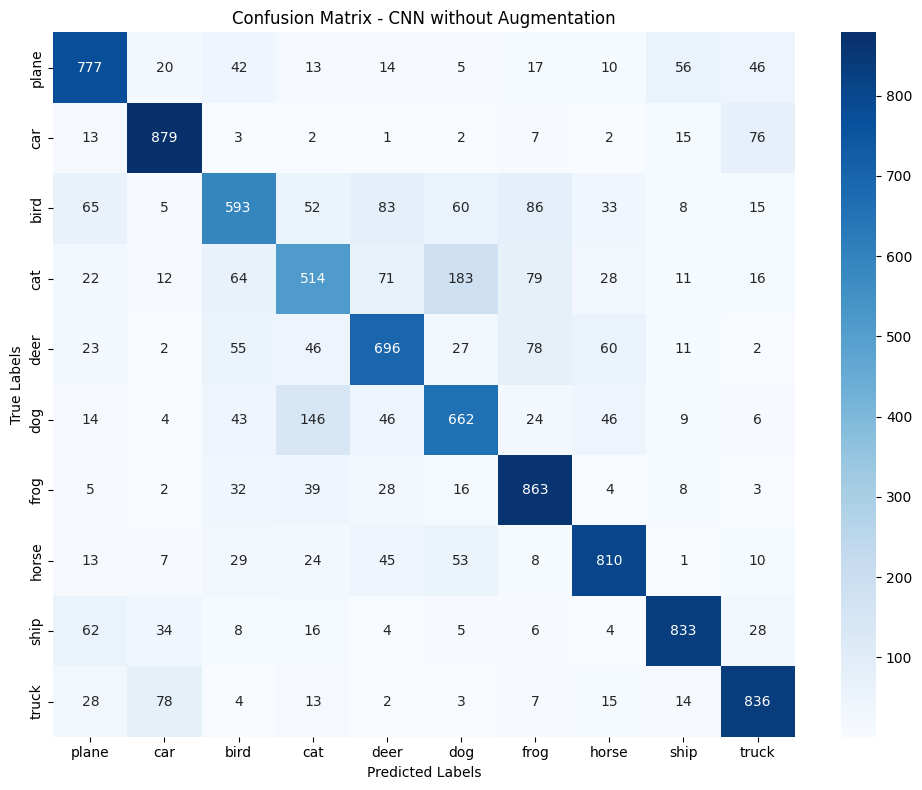


Classification Report:
              precision    recall  f1-score   support

       plane       0.76      0.78      0.77      1000
         car       0.84      0.88      0.86      1000
        bird       0.68      0.59      0.63      1000
         cat       0.59      0.51      0.55      1000
        deer       0.70      0.70      0.70      1000
         dog       0.65      0.66      0.66      1000
        frog       0.73      0.86      0.79      1000
       horse       0.80      0.81      0.81      1000
        ship       0.86      0.83      0.85      1000
       truck       0.81      0.84      0.82      1000

    accuracy                           0.75     10000
   macro avg       0.74      0.75      0.74     10000
weighted avg       0.74      0.75      0.74     10000



In [12]:
#confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

#Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - CNN without Augmentation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

#Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

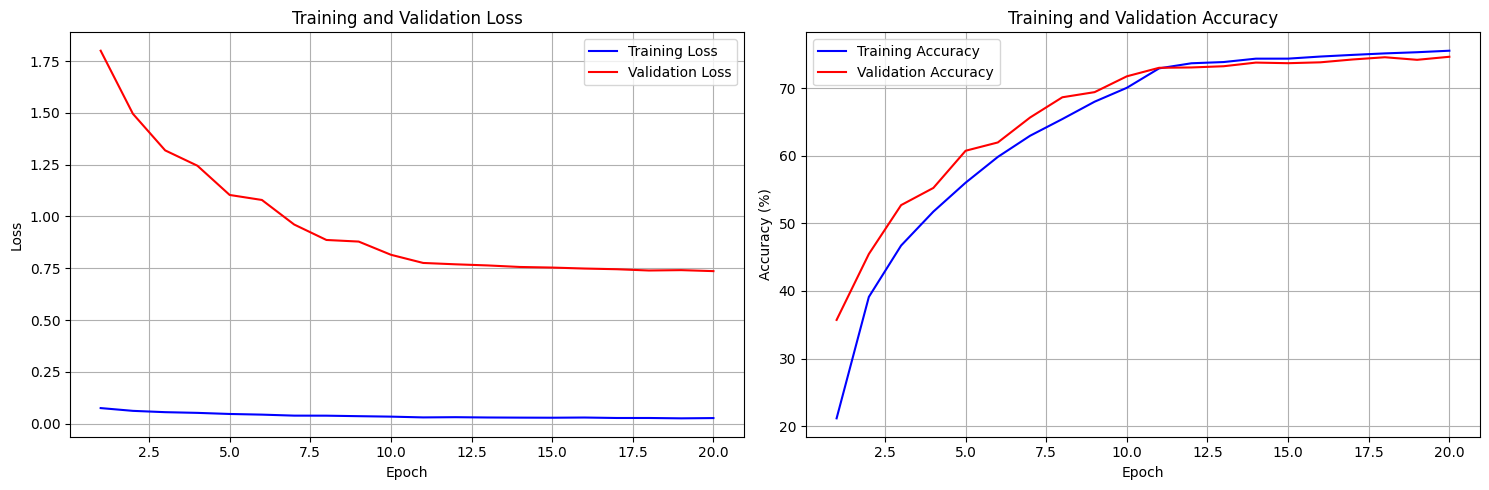


Final Results - CNN without Data Augmentation:
Best Training Accuracy: 75.53%
Final Training Accuracy: 75.53%
Best Validation Accuracy: 74.63%
Final Validation Accuracy: 74.63%


In [13]:
#Plot training and validation curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

#Plot losses
ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
ax1.plot(range(1, len(test_losses) + 1), test_losses, 'r-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

#Plot accuracies
ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(range(1, len(test_accuracies) + 1), test_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#Print final metrics
print(f"\nFinal Results - CNN without Data Augmentation:")
print(f"Best Training Accuracy: {max(train_accuracies):.2f}%")
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Best Validation Accuracy: {max(test_accuracies):.2f}%")
print(f"Final Validation Accuracy: {test_accuracies[-1]:.2f}%")


In [14]:
# Store results for comparison later
results_no_aug = {
    'model_type': 'CNN from scratch',
    'augmentation': False,
    'final_accuracy': final_accuracy,
    'best_accuracy': max(test_accuracies),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_losses': test_losses,
    'test_accuracies': test_accuracies,
    'confusion_matrix': cm
}

print("Results stored for comparison with other models.")
print(f"Model: CNN trained from scratch without data augmentation")
print(f"Final Test Accuracy: {final_accuracy:.2f}%")
print(f"Best Test Accuracy: {max(test_accuracies):.2f}%")

Results stored for comparison with other models.
Model: CNN trained from scratch without data augmentation
Final Test Accuracy: 74.63%
Best Test Accuracy: 74.63%


In [15]:
print("_"*25)
print("MODEL 2: CNN FROM SCRATCH WITH DATA AUGMENTATION")
print("_"*25)

transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

batch_size = 32

trainset_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=False, transform=transform_aug)
trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size,
                                             shuffle=True, num_workers=2)

testset_aug = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=False, transform=transform_no_aug)
testloader_aug = torch.utils.data.DataLoader(testset_aug, batch_size,
                                            shuffle=False, num_workers=2)

print("Augmented dataset loaded")
print(f"Training samples: {len(trainset_aug)}")
print(f"Test samples: {len(testset_aug)}")

_________________________
MODEL 2: CNN FROM SCRATCH WITH DATA AUGMENTATION
_________________________
Augmented dataset loaded
Training samples: 50000
Test samples: 10000


In [16]:
model_aug = TinyVGG(num_classes=10)
model_aug = model_aug.to(device)

print("Model 2 Architecture (same as Model 1):")
print(model_aug)
print(f"\nTotal parameters: {sum(p.numel() for p in model_aug.parameters()):,}")

Model 2 Architecture (same as Model 1):
TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=8192, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

Total parameters: 4,460,106


In [17]:
criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = optim.SGD(model_aug.parameters(), lr=0.001, momentum=0.9)
scheduler_aug = optim.lr_scheduler.StepLR(optimizer_aug, step_size=10, gamma=0.1)

In [18]:
print("Starting training with data augmentation...")

train_losses_aug, train_accuracies_aug, test_losses_aug, test_accuracies_aug = train_model(model_aug, trainloader_aug, testloader_aug, criterion_aug, optimizer_aug, scheduler_aug, num_epochs=30)

Starting training with data augmentation...
[Epoch 1, Batch   500] Loss: 2.300
[Epoch 1, Batch  1000] Loss: 2.183
[Epoch 1, Batch  1500] Loss: 1.947
Epoch [1/30] - Train Loss: 0.0757, Train Acc: 20.93%, Test Loss: 1.7998, Test Acc: 36.19%
[Epoch 2, Batch   500] Loss: 1.769
[Epoch 2, Batch  1000] Loss: 1.658
[Epoch 2, Batch  1500] Loss: 1.594
Epoch [2/30] - Train Loss: 0.0630, Train Acc: 39.30%, Test Loss: 1.4778, Test Acc: 46.03%
[Epoch 3, Batch   500] Loss: 1.515
[Epoch 3, Batch  1000] Loss: 1.482
[Epoch 3, Batch  1500] Loss: 1.429
Epoch [3/30] - Train Loss: 0.0576, Train Acc: 46.45%, Test Loss: 1.3796, Test Acc: 50.64%
[Epoch 4, Batch   500] Loss: 1.380
[Epoch 4, Batch  1000] Loss: 1.346
[Epoch 4, Batch  1500] Loss: 1.320
Epoch [4/30] - Train Loss: 0.0529, Train Acc: 51.45%, Test Loss: 1.2175, Test Acc: 56.26%
[Epoch 5, Batch   500] Loss: 1.285
[Epoch 5, Batch  1000] Loss: 1.228
[Epoch 5, Batch  1500] Loss: 1.217
Epoch [5/30] - Train Loss: 0.0490, Train Acc: 55.32%, Test Loss: 1.1464

In [19]:
PATH_aug = './cifar_cnn_with_aug.pth'
torch.save({
    'model_state_dict': model_aug.state_dict(),
    'optimizer_state_dict': optimizer_aug.state_dict(),
    'train_losses': train_losses_aug,
    'train_accuracies': train_accuracies_aug,
    'test_losses': test_losses_aug,
    'test_accuracies': test_accuracies_aug
}, PATH_aug)
print(f'Model 2 saved to {PATH_aug}')

Model 2 saved to ./cifar_cnn_with_aug.pth


In [20]:
predicted_labels_aug, true_labels_aug, final_accuracy_aug = evaluate_model(model_aug, testloader_aug, classes)

Final Test Accuracy: 74.86%

Per-class Accuracy:
plane: 78.50%
car: 88.70%
bird: 60.90%
cat: 54.50%
deer: 70.20%
dog: 67.20%
frog: 81.30%
horse: 79.50%
ship: 85.00%
truck: 82.80%


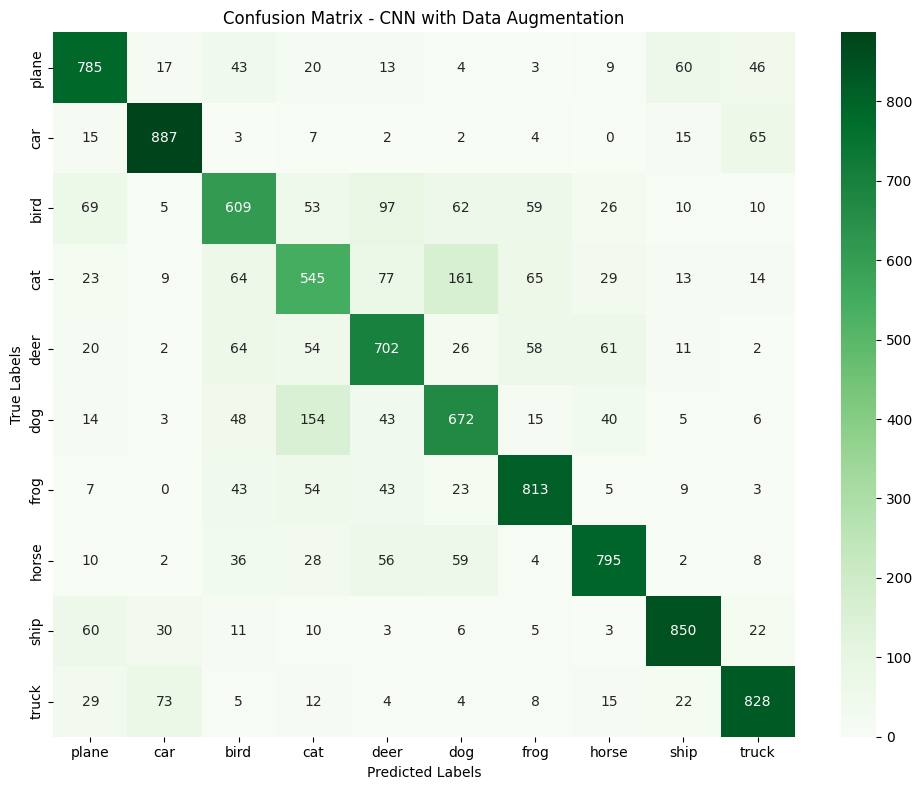


Classification Report:
              precision    recall  f1-score   support

       plane       0.76      0.79      0.77      1000
         car       0.86      0.89      0.87      1000
        bird       0.66      0.61      0.63      1000
         cat       0.58      0.55      0.56      1000
        deer       0.68      0.70      0.69      1000
         dog       0.66      0.67      0.67      1000
        frog       0.79      0.81      0.80      1000
       horse       0.81      0.80      0.80      1000
        ship       0.85      0.85      0.85      1000
       truck       0.82      0.83      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [21]:
# Generate confusion matrix for Model 2
cm_aug = confusion_matrix(true_labels_aug, predicted_labels_aug)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - CNN with Data Augmentation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels_aug, predicted_labels_aug, target_names=classes))

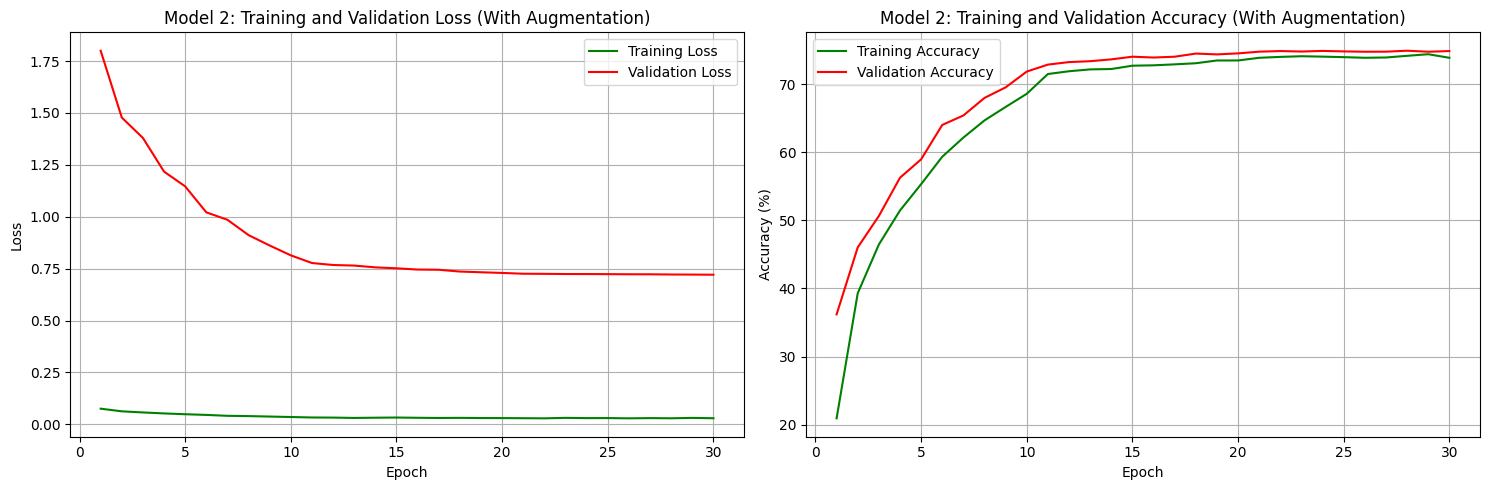


Model 2 Results - CNN with Data Augmentation:
Best Training Accuracy: 74.40%
Final Training Accuracy: 73.87%
Best Validation Accuracy: 74.91%
Final Validation Accuracy: 74.86%


In [22]:
# Plot Model 2 training and validation curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
ax1.plot(range(1, len(train_losses_aug) + 1), train_losses_aug, 'g-', label='Training Loss')
ax1.plot(range(1, len(test_losses_aug) + 1), test_losses_aug, 'r-', label='Validation Loss')
ax1.set_title('Model 2: Training and Validation Loss (With Augmentation)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(range(1, len(train_accuracies_aug) + 1), train_accuracies_aug, 'g-', label='Training Accuracy')
ax2.plot(range(1, len(test_accuracies_aug) + 1), test_accuracies_aug, 'r-', label='Validation Accuracy')
ax2.set_title('Model 2: Training and Validation Accuracy (With Augmentation)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print Model 2 final metrics
print(f"\nModel 2 Results - CNN with Data Augmentation:")
print(f"Best Training Accuracy: {max(train_accuracies_aug):.2f}%")
print(f"Final Training Accuracy: {train_accuracies_aug[-1]:.2f}%")
print(f"Best Validation Accuracy: {max(test_accuracies_aug):.2f}%")
print(f"Final Validation Accuracy: {test_accuracies_aug[-1]:.2f}%")

In [23]:
# Store Model 2 results for final comparison
results_with_aug = {
    'model_type': 'CNN from scratch',
    'augmentation': True,
    'final_accuracy': final_accuracy_aug,
    'best_accuracy': max(test_accuracies_aug),
    'train_losses': train_losses_aug,
    'train_accuracies': train_accuracies_aug,
    'test_losses': test_losses_aug,
    'test_accuracies': test_accuracies_aug,
    'confusion_matrix': cm_aug
}

print("Model 2 results stored for comparison.")
print(f"Model: CNN trained from scratch WITH data augmentation")
print(f"Final Test Accuracy: {final_accuracy_aug:.2f}%")
print(f"Best Test Accuracy: {max(test_accuracies_aug):.2f}%")

Model 2 results stored for comparison.
Model: CNN trained from scratch WITH data augmentation
Final Test Accuracy: 74.86%
Best Test Accuracy: 74.91%


In [28]:
transform_pt_no_aug = transforms.Compose([
    transforms.Resize((224, 224)),  #Resize for pre-trained models
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #From ImageNet stats
])

batch_size = 64

# Load CIFAR-10 dataset for pre-trained model
trainset_pt = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                   download=False, transform=transform_pt_no_aug)
trainloader_pt = torch.utils.data.DataLoader(trainset_pt, batch_size=batch_size,
                                                     shuffle=True, num_workers=2)

testset_pt = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                  download=False, transform=transform_pt_no_aug)
testloader_pt = torch.utils.data.DataLoader(testset_pt, batch_size=batch_size,
                                                    shuffle=False, num_workers=2)

print("Pre-trained model dataset loaded")
print(f"Training samples: {len(trainset_pt)}")
print(f"Test samples: {len(testset_pt)}")

Pre-trained model dataset loaded
Training samples: 50000
Test samples: 10000


In [29]:
#The pre trained model
from torchvision.models import ResNet18_Weights
model_pt = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_pt.fc = nn.Linear(512, 10)

#Move model to device
model_pt = model_pt.to(device)

#Print Model architecture
print("Model 3 Architecture (Pre-trained ResNet18):")
print(f"Total parameters: {sum(p.numel() for p in model_pt.parameters()):,}")
print(f"Final layer: {model_pt.fc}")
print(f"Using device: {device}")

Model 3 Architecture (Pre-trained ResNet18):
Total parameters: 11,181,642
Final layer: Linear(in_features=512, out_features=10, bias=True)
Using device: cuda:0


In [30]:
#Optimizer and Scheduler (Adam)
criterion_pt = nn.CrossEntropyLoss()
optimizer_pt = optim.Adam(model_pt.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_pt = optim.lr_scheduler.StepLR(optimizer_pt, step_size=5, gamma=0.1)

In [31]:
#Fine tune
print("Starting fine tuning without data augmentation...")

train_losses_pt, train_accuracies_pt, test_losses_pt, test_accuracies_pt = train_model(
    model_pt, trainloader_pt, testloader_pt, criterion_pt, optimizer_pt, scheduler_pt, num_epochs=10
)

Starting fine tuning without data augmentation...
[Epoch 1, Batch   500] Loss: 0.637
Epoch [1/10] - Train Loss: 0.1661, Train Acc: 80.52%, Test Loss: 0.5518, Test Acc: 80.80%
[Epoch 2, Batch   500] Loss: 0.354
Epoch [2/10] - Train Loss: 0.1272, Train Acc: 87.88%, Test Loss: 0.4435, Test Acc: 84.70%
[Epoch 3, Batch   500] Loss: 0.277
Epoch [3/10] - Train Loss: 0.1055, Train Acc: 90.31%, Test Loss: 0.3954, Test Acc: 86.55%
[Epoch 4, Batch   500] Loss: 0.225
Epoch [4/10] - Train Loss: 0.0948, Train Acc: 91.87%, Test Loss: 0.4151, Test Acc: 86.66%
[Epoch 5, Batch   500] Loss: 0.199
Epoch [5/10] - Train Loss: 0.0791, Train Acc: 92.85%, Test Loss: 0.3937, Test Acc: 87.40%
[Epoch 6, Batch   500] Loss: 0.075
Epoch [6/10] - Train Loss: 0.0173, Train Acc: 98.02%, Test Loss: 0.2108, Test Acc: 92.86%
[Epoch 7, Batch   500] Loss: 0.025
Epoch [7/10] - Train Loss: 0.0089, Train Acc: 99.48%, Test Loss: 0.2115, Test Acc: 93.18%
[Epoch 8, Batch   500] Loss: 0.011
Epoch [8/10] - Train Loss: 0.0041, Train

In [32]:
#Save the Fine tuned model
PATH_pt = './cifar_resnet18_pretrained.pth'
torch.save({
    'model_state_dict': model_pt.state_dict(),
    'optimizer_state_dict': optimizer_pt.state_dict(),
    'train_losses': train_losses_pt,
    'train_accuracies': train_accuracies_pt,
    'test_losses': test_losses_pt,
    'test_accuracies': test_accuracies_pt
}, PATH_pt)
print(f'Model 3 saved to {PATH_pt}')

Model 3 saved to ./cifar_resnet18_pretrained.pth


In [33]:
#Evaluation phase
predicted_labels_pt, true_labels_pt, final_accuracy_pt = evaluate_model(model_pt, testloader_pt, classes)

Final Test Accuracy: 93.26%

Per-class Accuracy:
plane: 96.50%
car: 96.90%
bird: 91.60%
cat: 84.70%
deer: 93.70%
dog: 90.00%
frog: 95.80%
horse: 94.60%
ship: 93.90%
truck: 94.90%


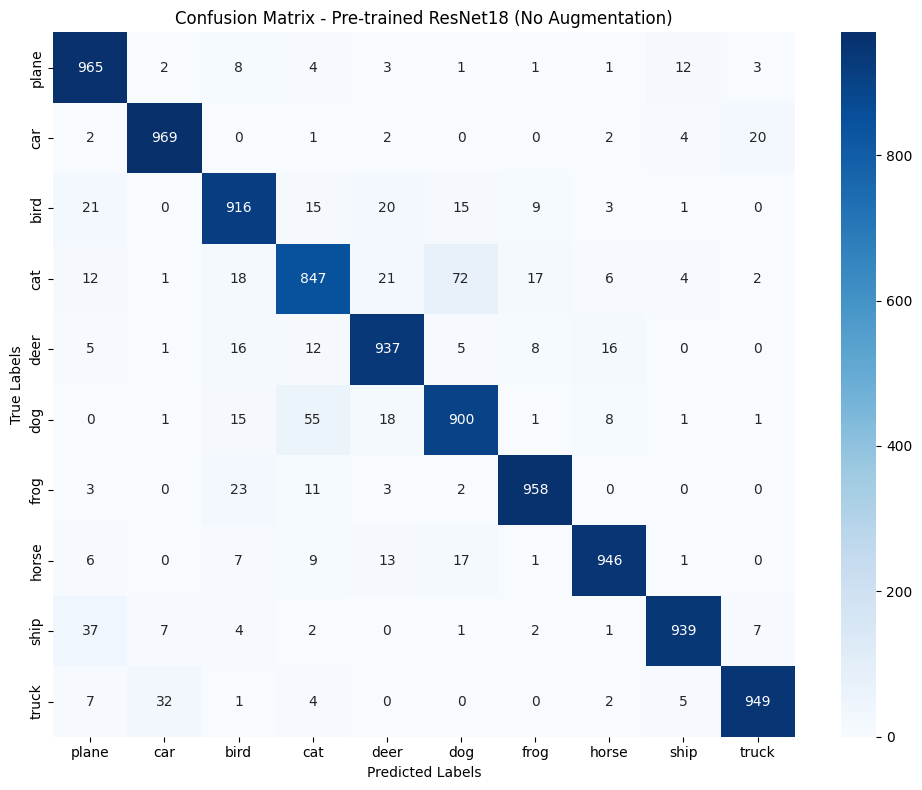


Classification Report:
              precision    recall  f1-score   support

       plane       0.91      0.96      0.94      1000
         car       0.96      0.97      0.96      1000
        bird       0.91      0.92      0.91      1000
         cat       0.88      0.85      0.86      1000
        deer       0.92      0.94      0.93      1000
         dog       0.89      0.90      0.89      1000
        frog       0.96      0.96      0.96      1000
       horse       0.96      0.95      0.95      1000
        ship       0.97      0.94      0.95      1000
       truck       0.97      0.95      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [34]:
# Generate confusion matrix for Model 3
cm_pt = confusion_matrix(true_labels_pt, predicted_labels_pt)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Pre-trained ResNet18 (No Augmentation)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels_pt, predicted_labels_pt, target_names=classes))

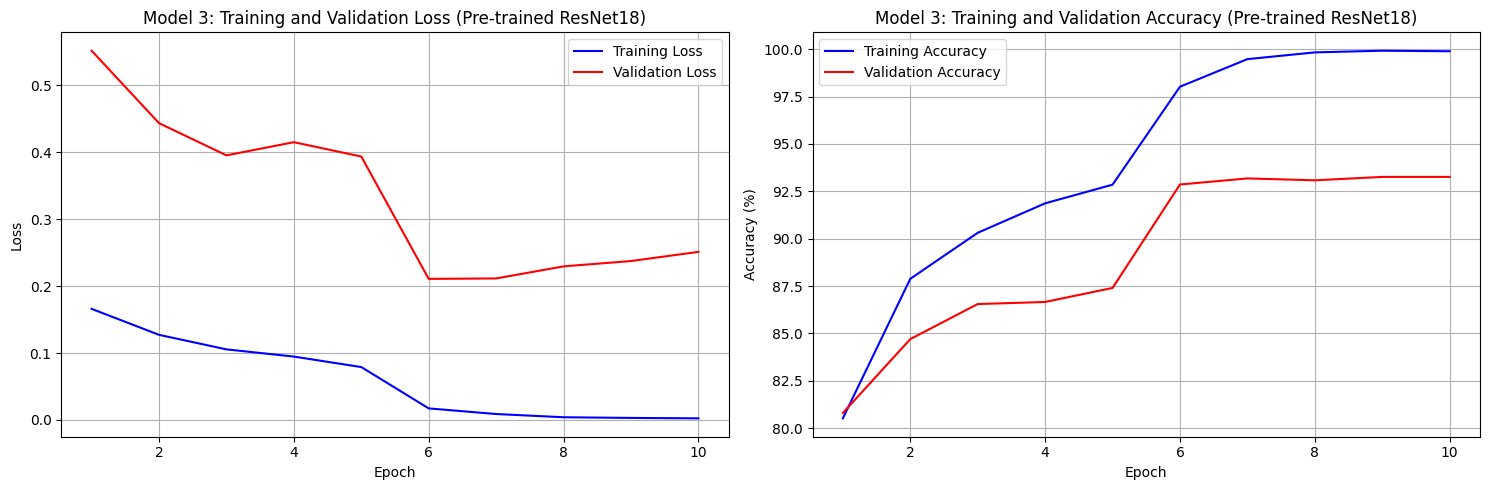


Model 3 Results - Pre-trained ResNet18 (No Augmentation):
Best Training Accuracy: 99.92%
Final Training Accuracy: 99.89%
Best Validation Accuracy: 93.26%
Final Validation Accuracy: 93.26%


In [35]:
# Plot Model 3 training and validation curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
ax1.plot(range(1, len(train_losses_pt) + 1), train_losses_pt, 'b-', label='Training Loss')
ax1.plot(range(1, len(test_losses_pt) + 1), test_losses_pt, 'r-', label='Validation Loss')
ax1.set_title('Model 3: Training and Validation Loss (Pre-trained ResNet18)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(range(1, len(train_accuracies_pt) + 1), train_accuracies_pt, 'b-', label='Training Accuracy')
ax2.plot(range(1, len(test_accuracies_pt) + 1), test_accuracies_pt, 'r-', label='Validation Accuracy')
ax2.set_title('Model 3: Training and Validation Accuracy (Pre-trained ResNet18)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print Model 3 final metrics
print(f"\nModel 3 Results - Pre-trained ResNet18 (No Augmentation):")
print(f"Best Training Accuracy: {max(train_accuracies_pt):.2f}%")
print(f"Final Training Accuracy: {train_accuracies_pt[-1]:.2f}%")
print(f"Best Validation Accuracy: {max(test_accuracies_pt):.2f}%")
print(f"Final Validation Accuracy: {test_accuracies_pt[-1]:.2f}%")

In [36]:
# Store Model 3 results for final comparison
results_pretrained = {
    'model_type': 'Pre-trained ResNet18',
    'augmentation': False,
    'final_accuracy': final_accuracy_pt,
    'best_accuracy': max(test_accuracies_pt),
    'train_losses': train_losses_pt,
    'train_accuracies': train_accuracies_pt,
    'test_losses': test_losses_pt,
    'test_accuracies': test_accuracies_pt,
    'confusion_matrix': cm_pt,
    'epochs': 10
}

print("Model 3 results stored for comparison.")
print(f"Model: Pre-trained ResNet18 WITHOUT data augmentation")
print(f"Final Test Accuracy: {final_accuracy_pt:.2f}%")
print(f"Best Test Accuracy: {max(test_accuracies_pt):.2f}%")

Model 3 results stored for comparison.
Model: Pre-trained ResNet18 WITHOUT data augmentation
Final Test Accuracy: 93.26%
Best Test Accuracy: 93.26%


In [37]:
transform_pt_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),      #same as Model 2
    transforms.Resize((224, 224)),               #Resize for pre-trained models
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #From ImageNet stats
])

batch_size = 64

# Load CIFAR-10 dataset for pre-trained model with augmentation
trainset_pt_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=False, transform=transform_pt_aug)
trainloader_pt_aug = torch.utils.data.DataLoader(trainset_pt_aug, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

# Test set remains the same (no augmentation for testing)
testset_pt_aug = torchvision.datasets.CIFAR10(root='./data', train=False,
                                              download=False, transform=transform_pt_no_aug)
testloader_pt_aug = torch.utils.data.DataLoader(testset_pt_aug, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

print("Pre-trained model dataset with augmentation loaded")
print(f"Training samples: {len(trainset_pt_aug)}")
print(f"Test samples: {len(testset_pt_aug)}")

Pre-trained model dataset with augmentation loaded
Training samples: 50000
Test samples: 10000


In [38]:
model_pt_aug = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_pt_aug.fc = nn.Linear(512, 10)  #Replace final layer for CIFAR-10
model_pt_aug = model_pt_aug.to(device)

print("Model 4 Architecture (same as Model 3 but fresh weights):")
print(f"Total parameters: {sum(p.numel() for p in model_pt_aug.parameters()):,}")
print(f"Final layer: {model_pt_aug.fc}")
print(f"Using device: {device}")

Model 4 Architecture (same as Model 3 but fresh weights):
Total parameters: 11,181,642
Final layer: Linear(in_features=512, out_features=10, bias=True)
Using device: cuda:0


In [39]:
criterion_pt_aug = nn.CrossEntropyLoss()
optimizer_pt_aug = optim.Adam(model_pt_aug.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_pt_aug = optim.lr_scheduler.StepLR(optimizer_pt_aug, step_size=5, gamma=0.1)

In [40]:
print("Starting fine tuning with data augmentation...")

train_losses_pt_aug, train_accuracies_pt_aug, test_losses_pt_aug, test_accuracies_pt_aug = train_model(
    model_pt_aug, trainloader_pt_aug, testloader_pt_aug, 
    criterion_pt_aug, optimizer_pt_aug, scheduler_pt_aug, num_epochs=15)

Starting fine tuning with data augmentation...
[Epoch 1, Batch   500] Loss: 0.629
Epoch [1/15] - Train Loss: 0.1645, Train Acc: 80.67%, Test Loss: 0.4509, Test Acc: 84.81%
[Epoch 2, Batch   500] Loss: 0.369
Epoch [2/15] - Train Loss: 0.1309, Train Acc: 87.55%, Test Loss: 0.3768, Test Acc: 87.17%
[Epoch 3, Batch   500] Loss: 0.319
Epoch [3/15] - Train Loss: 0.1121, Train Acc: 89.31%, Test Loss: 0.4404, Test Acc: 85.18%
[Epoch 4, Batch   500] Loss: 0.275
Epoch [4/15] - Train Loss: 0.1031, Train Acc: 90.42%, Test Loss: 0.3704, Test Acc: 87.46%
[Epoch 5, Batch   500] Loss: 0.248
Epoch [5/15] - Train Loss: 0.0947, Train Acc: 91.47%, Test Loss: 0.4253, Test Acc: 85.89%
[Epoch 6, Batch   500] Loss: 0.129
Epoch [6/15] - Train Loss: 0.0346, Train Acc: 96.05%, Test Loss: 0.1854, Test Acc: 93.53%
[Epoch 7, Batch   500] Loss: 0.073
Epoch [7/15] - Train Loss: 0.0240, Train Acc: 97.77%, Test Loss: 0.1765, Test Acc: 94.06%
[Epoch 8, Batch   500] Loss: 0.051
Epoch [8/15] - Train Loss: 0.0181, Train Ac

In [41]:
PATH_pt_aug = './cifar_resnet18_pretrained_aug.pth'
torch.save({
    'model_state_dict': model_pt_aug.state_dict(),
    'optimizer_state_dict': optimizer_pt_aug.state_dict(),
    'train_losses': train_losses_pt_aug,
    'train_accuracies': train_accuracies_pt_aug,
    'test_losses': test_losses_pt_aug,
    'test_accuracies': test_accuracies_pt_aug
}, PATH_pt_aug)
print(f'Model 4 saved to {PATH_pt_aug}')

Model 4 saved to ./cifar_resnet18_pretrained_aug.pth


In [42]:
predicted_labels_pt_aug, true_labels_pt_aug, final_accuracy_pt_aug = evaluate_model(model_pt_aug, testloader_pt_aug, classes)

Final Test Accuracy: 94.63%

Per-class Accuracy:
plane: 96.70%
car: 97.70%
bird: 93.50%
cat: 86.90%
deer: 96.40%
dog: 90.60%
frog: 96.30%
horse: 96.10%
ship: 96.50%
truck: 95.60%


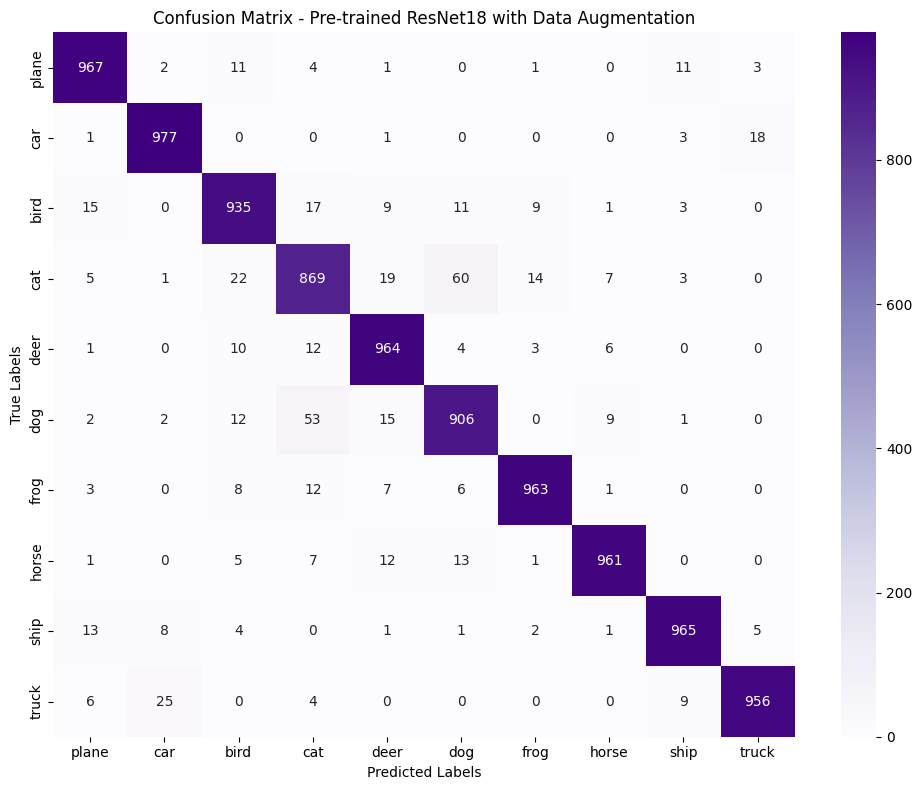


Classification Report:
              precision    recall  f1-score   support

       plane       0.95      0.97      0.96      1000
         car       0.96      0.98      0.97      1000
        bird       0.93      0.94      0.93      1000
         cat       0.89      0.87      0.88      1000
        deer       0.94      0.96      0.95      1000
         dog       0.91      0.91      0.91      1000
        frog       0.97      0.96      0.97      1000
       horse       0.97      0.96      0.97      1000
        ship       0.97      0.96      0.97      1000
       truck       0.97      0.96      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [43]:
#Generate confusion matrix for Model 4
cm_pt_aug = confusion_matrix(true_labels_pt_aug, predicted_labels_pt_aug)

#Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_pt_aug, annot=True, fmt='d', cmap='Purples', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Pre-trained ResNet18 with Data Augmentation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

#Print classification report
print("\nClassification Report:")
print(classification_report(true_labels_pt_aug, predicted_labels_pt_aug, target_names=classes))

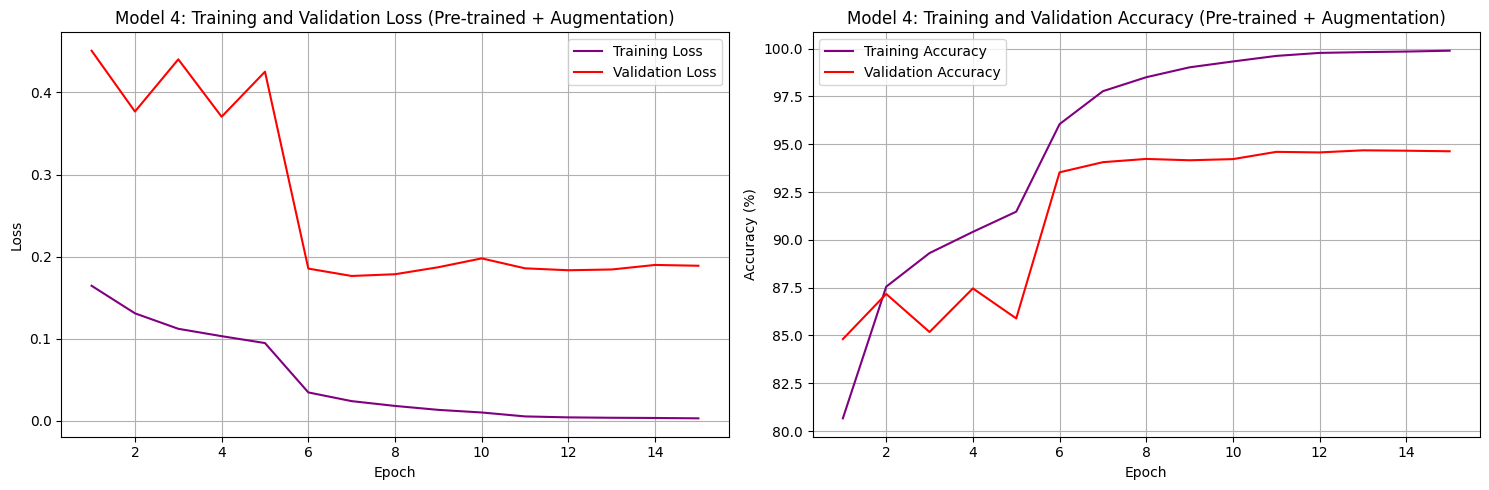


Model 4 Results - Pre-trained ResNet18 WITH Data Augmentation:
Best Training Accuracy: 99.89%
Final Training Accuracy: 99.89%
Best Validation Accuracy: 94.68%
Final Validation Accuracy: 94.63%


In [44]:
#Plot Model 4 training and validation curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

#Plot losses
ax1.plot(range(1, len(train_losses_pt_aug) + 1), train_losses_pt_aug, 'purple', label='Training Loss')
ax1.plot(range(1, len(test_losses_pt_aug) + 1), test_losses_pt_aug, 'r-', label='Validation Loss')
ax1.set_title('Model 4: Training and Validation Loss (Pre-trained + Augmentation)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

#Plot accuracies
ax2.plot(range(1, len(train_accuracies_pt_aug) + 1), train_accuracies_pt_aug, 'purple', label='Training Accuracy')
ax2.plot(range(1, len(test_accuracies_pt_aug) + 1), test_accuracies_pt_aug, 'r-', label='Validation Accuracy')
ax2.set_title('Model 4: Training and Validation Accuracy (Pre-trained + Augmentation)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#Print Model 4 final metrics
print(f"\nModel 4 Results - Pre-trained ResNet18 WITH Data Augmentation:")
print(f"Best Training Accuracy: {max(train_accuracies_pt_aug):.2f}%")
print(f"Final Training Accuracy: {train_accuracies_pt_aug[-1]:.2f}%")
print(f"Best Validation Accuracy: {max(test_accuracies_pt_aug):.2f}%")
print(f"Final Validation Accuracy: {test_accuracies_pt_aug[-1]:.2f}%")

In [45]:
results_pretrained_aug = {
    'model_type': 'Pre-trained ResNet18',
    'augmentation': True,
    'final_accuracy': final_accuracy_pt_aug,
    'best_accuracy': max(test_accuracies_pt_aug),
    'train_losses': train_losses_pt_aug,
    'train_accuracies': train_accuracies_pt_aug,
    'test_losses': test_losses_pt_aug,
    'test_accuracies': test_accuracies_pt_aug,
    'confusion_matrix': cm_pt_aug,
    'epochs': 12
}

print("Model 4 results stored for comparison.")
print(f"Model: Pre-trained ResNet18 WITH data augmentation")
print(f"Final Test Accuracy: {final_accuracy_pt_aug:.2f}%")
print(f"Best Test Accuracy: {max(test_accuracies_pt_aug):.2f}%")

Model 4 results stored for comparison.
Model: Pre-trained ResNet18 WITH data augmentation
Final Test Accuracy: 94.63%
Best Test Accuracy: 94.68%
